## Thêm thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


## Tiền xử lý

### read data

In [2]:
# Load the data
df = pd.read_csv('PFE-Pfizer.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,41.375713,41.546490,41.072105,41.138519,33.767422,26667781
1,2019-03-04,41.214420,41.356735,40.683113,40.863377,33.541576,22805820
2,2019-03-05,40.882355,41.034157,40.654648,40.692600,33.401398,26529812
3,2019-03-06,40.626186,40.673622,39.487667,39.715370,32.599270,22410359
4,2019-03-07,39.715370,39.743832,39.136623,39.269451,32.233242,29046132
...,...,...,...,...,...,...,...
1254,2024-02-23,27.750000,28.090000,27.690001,27.760000,27.760000,33182600
1255,2024-02-26,27.670000,27.670000,27.070000,27.180000,27.180000,45685500
1256,2024-02-27,27.120001,27.200001,26.809999,26.889999,26.889999,38598400
1257,2024-02-28,26.959999,27.240000,26.820000,27.040001,27.040001,31010200


### Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df = df.set_index(pd.DatetimeIndex(df['Date'].values))

# Create new dataframe with Date and Close
df_close = pd.DataFrame(df, columns=['Close'])

### Data normalization

In [4]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1, 1))

### Data splitting

In [5]:
# Split the data into training and test sets
train_size = int(len(df_close) * 0.7)
test_size = len(df_close) - train_size

train_data = df_close[:train_size]
test_data = df_close[train_size:]

In [6]:
# Create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
	
time_step = 100

# Get lost data for test
train_last_windowsize = train_data[-time_step:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Model training and testing

In [7]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# Using early stopping to prevent overfitting
earlystop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=earlystop)

Epoch 1/100

13/13 [==============================] - 11s 87ms/step - loss: 0.0550
Epoch 2/100
13/13 [==============================] - 1s 105ms/step - loss: 0.0131
Epoch 3/100
13/13 [==============================] - 2s 119ms/step - loss: 0.0075
Epoch 4/100
13/13 [==============================] - 2s 123ms/step - loss: 0.0049
Epoch 5/100
13/13 [==============================] - 2s 143ms/step - loss: 0.0047
Epoch 6/100
13/13 [==============================] - 2s 121ms/step - loss: 0.0042
Epoch 7/100
13/13 [==============================] - 1s 111ms/step - loss: 0.0041
Epoch 8/100
13/13 [==============================] - 1s 112ms/step - loss: 0.0039
Epoch 9/100
13/13 [==============================] - 1s 103ms/step - loss: 0.0036
Epoch 10/100
13/13 [==============================] - 1s 107ms/step - loss: 0.0034
Epoch 11/100
13/13 [==============================] - 1s 104ms/step - loss: 0.0035
Epoch 12/100
13/13 [==============================] - 1s 106ms/step - loss: 0.0036
Epoch 13/100

### Testing process

In [9]:
# Predict
y_pred = model.predict(X_test)

12/12 [==============================] - 2s 41ms/step


### Evaluate model

In [10]:
# Evaluate the accuracy of the test set
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSLE on Test dataset: {test_msle}")

MAPE on Test dataset: 726845498167.6431
RMSE on Test dataset: 0.021388350666530193
MSLE on Test dataset: 0.0002512304421140206


## Predicting the next 30 days

### Preparing the prediction data

In [11]:
# Predict the next 30 days
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
prediction_next30_days = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        prediction_next30_days.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())

# Print predictions for the next 30 days
print(prediction_next30_days)

[[0.02922099083662033], [0.026740405708551407], [0.02613043785095215], [0.026497121900320053], [0.02739356830716133], [0.02858869731426239], [0.02995670586824417], [0.031424377113580704], [0.03294617310166359], [0.03449220955371857], [0.03604258596897125], [0.037584088742733], [0.0391085110604763], [0.04061128944158554], [0.042090483009815216], [0.04354611784219742], [0.04497939720749855], [0.04639230668544769], [0.04778718203306198], [0.049166351556777954], [0.050532057881355286], [0.05188627541065216], [0.0532306507229805], [0.05456648766994476], [0.055894799530506134], [0.057216282933950424], [0.05853140726685524], [0.05984044820070267], [0.06114354729652405], [0.062440723180770874]]


### Preparing the forecast date index

In [12]:
# Print predictions for the next 30 days
print(prediction_next30_days)

# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')

# Convert predictions back to original scale
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)
y_pred = scaler.inverse_transform(y_pred)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

[[0.02922099083662033], [0.026740405708551407], [0.02613043785095215], [0.026497121900320053], [0.02739356830716133], [0.02858869731426239], [0.02995670586824417], [0.031424377113580704], [0.03294617310166359], [0.03449220955371857], [0.03604258596897125], [0.037584088742733], [0.0391085110604763], [0.04061128944158554], [0.042090483009815216], [0.04354611784219742], [0.04497939720749855], [0.04639230668544769], [0.04778718203306198], [0.049166351556777954], [0.050532057881355286], [0.05188627541065216], [0.0532306507229805], [0.05456648766994476], [0.055894799530506134], [0.057216282933950424], [0.05853140726685524], [0.05984044820070267], [0.06114354729652405], [0.062440723180770874]]


## Visualization

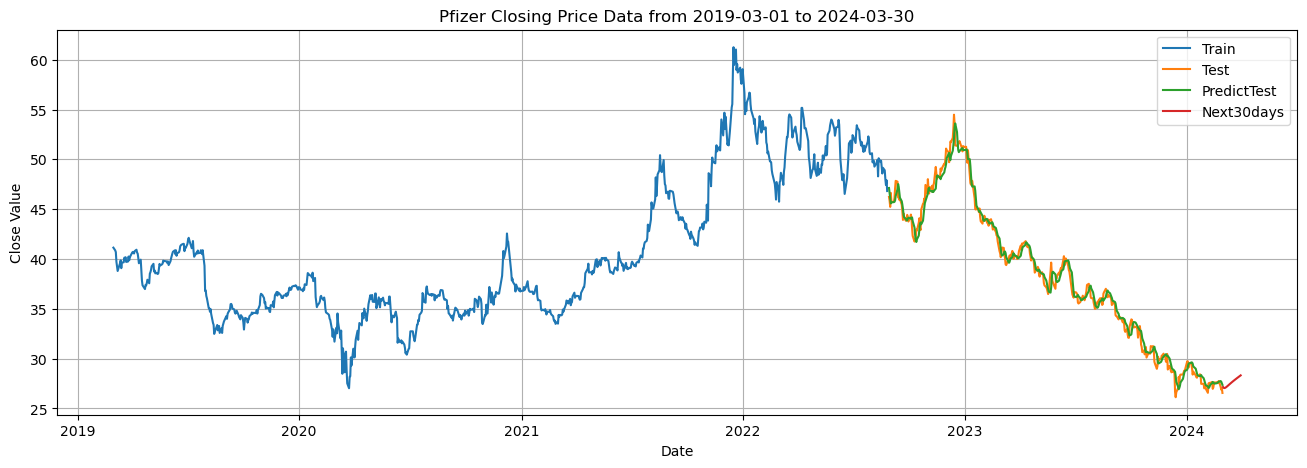

In [13]:
# Plotting
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], train_data, label='Train')
plt.plot(df.index[train_size:], test_data, label='Test')
plt.plot(df.index[train_size:], y_pred, label='PredictTest')
plt.plot(future_dates, prediction_next30_days, label='Next30days')

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title(f"Pfizer Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")
plt.legend()
plt.grid()
plt.savefig('Image/LSTM_73_30days_PFE.png')
plt.show()